In [11]:
# 1 A. Import Libraries
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
import keras
import spacy
import re
from tensorflow.keras import regularizers
!pip install pycm
from pycm import ConfusionMatrix

In [70]:
# 1 B. Importing data set from  Google drive 

re.compile('<title>(.*)</title>')

trainfile = "/content/drive/My Drive/Colab Notebooks/training.1600000.processed.noemoticon.csv"
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
df_train = pd.read_csv(trainfile,
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
y_label=df_train.iloc[:,0].values
print(1)

NUMTRAIN = 800000
train_set = df_train[['ids','sentiment', 'text']].sample(NUMTRAIN)
X_train = train_set.drop("sentiment", axis=1) # drop labels for training set
y_train = train_set["sentiment"].copy()

NUMTEST = 100000
test_set = df_train[['ids','sentiment', 'text']].sample(NUMTEST)
X_test = test_set.drop("sentiment", axis=1) # drop labels for training set
y_test = test_set["sentiment"].copy()
print(2)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)                    
y_train = keras.utils.to_categorical(y_train)

y_test = label_encoder.fit_transform(y_test)                    
y_test = keras.utils.to_categorical(y_test)

1
2


In [81]:
# 1 C. Check GPU availability
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


Version:  2.3.0
Eager mode:  True
GPU is available


In [83]:
#2 A. Print atleast two tweets 
print( 'Negative Class (Tweet) : '+df_train.iloc[1]['text'])
print( 'Positive Class (Tweet) : '+df_train.iloc[-1]['text'])

Negative Class (Tweet) : is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Positive Class (Tweet) : happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H 


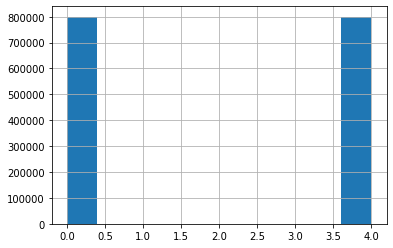

In [84]:
#2 B . Plot a bar graph
df_train.sentiment.hist()

In [71]:
# 2 D. Print the shapes of train and test data
# idx=np.random.randint(0,8000,8000)
# test_idx=np.concatenate((idx,idx+8000))

# print(idx)
# X_test=df_train.iloc[test_idx]
# X_test=X_test.columns[]
# y_test=y_label[test_idx]

# X_train = df_train.drop(test_idx)
# # X_train=np.delete(data,test_idx,axis=0)
# y_train=np.delete(y_label,test_idx ,axis=0)

print('X_train shape : '+ str(X_train.shape))
print('y_train shape : '+ str(y_train.shape))
print('X_test  shape : '+ str(X_test.shape))
print('y_test  shape : '+ str(y_test.shape))

X_train shape : (800000, 2)
y_train shape : (800000, 2)
X_test  shape : (100000, 2)
y_test  shape : (100000, 2)


3.Data Pre-processing

In [72]:
#3 A. Preprocessing of tweets data by removing stopwords

print(3)
def text_processing(tweet):
    
    
    # remove https links
    clean_tweet = re.sub(r'http\S+', '', tweet)
    # remove punctuation marks
    punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    clean_tweet = ''.join(ch for ch in clean_tweet if ch not in set(punctuation))
    # convert text to lowercase
    clean_tweet = clean_tweet.lower()
    # remove numbers
    clean_tweet = re.sub('\d', ' ', clean_tweet)
    # remove whitespaces
    clean_tweet = ' '.join(clean_tweet.split())
    return clean_tweet


print(4)
# function to lemmatize text
def lemmatization(tweets):
    lemma_tweet = []
    for i in tweets:
        t = [token.lemma_ for token in nlp(i)]
        lemma_tweet.append(' '.join(t))
    return lemma_tweet

# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
print(5)
X_train['clean_tweet'] = X_train['text'].apply(lambda x: text_processing(x))
X_test['clean_tweet'] = X_test['text'].apply(lambda x: text_processing(x))
print(6)
X_train['clean_tweet'] = lemmatization(X_train['clean_tweet'])
X_test['clean_tweet'] = lemmatization(X_test['clean_tweet'])

print(7)

3
4
5
6
7


In [73]:
X_train.to_csv('/content/drive/My Drive/Colab Notebooks/data/X_train.csv')
X_test.to_csv('/content/drive/My Drive/Colab Notebooks/data/X_test.csv')

np.save('/content/drive/My Drive/Colab Notebooks/data/y_train',y_train)
np.save('/content/drive/My Drive/Colab Notebooks/data/y_test',y_test)

In [74]:
# Load the clean train set and test set
X_train=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/X_train.csv')
X_test =pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/X_test.csv')

y_train= np.load('/content/drive/My Drive/Colab Notebooks/data/y_train.npy')
y_test= np.load('/content/drive/My Drive/Colab Notebooks/data/y_test.npy')

X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values


Model Building and compilation

In [76]:
#3 B.Please use this pre-trained embedding layer from TensorFlow hub for this assignment
MODEL = "nnlm-en-dim128"
VERSION = 2
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)


# 4. Sequential Model layers- Using 3 dense layers with L2 regularization to all the layers and one layer of dropout with every layer
hub_layer1 = hub.KerasLayer(URL, output_shape=[128], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = keras.Sequential()
model.add(hub_layer1)
model.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

# Reasons :- Add one layer of dropout at the appropriate position and give reasons.
# Dropout is just a regularization technique for preventing overfitting in the network. It sets a node's weight to zero with a given probability
# during training, reducing the number of weights required for training at each iteration. It can be applied for each layer of the network 
# (regardless if it is fully connected or convolutional), or after selected layers. To which layers dropout is applied is really just a design decision for what results in best performance.

model.summary()

#5 Compile the model with the appropriate loss function and appropriate optimizer.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Reaons : Use an appropriate optimizer. Give reasons for the choice of learning rate and its value
# Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
# The method is too fast and converges rapidly.
# Rectifies vanishing learning rate, high variance.


https://tfhub.dev/google/nnlm-en-dim128/2


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)               

Model Training

In [77]:
# 6 A. Train the model for an appropriate number of epochs
# model.load_weights('/content/drive/My Drive/Colab Notebooks/data/model.weights')

hist = model.fit(X_train, 
                 y_train, 
                 epochs=25, 
                 batch_size=64, 
                 validation_split=.3,
                 verbose = 1)

Epoch 1/25
8750/8750 [==============================] - 84s 10ms/step - loss: 0.6540 - accuracy: 0.6954 - val_loss: 0.6091 - val_accuracy: 0.7106
Epoch 2/25
8750/8750 [==============================] - 83s 9ms/step - loss: 0.6216 - accuracy: 0.7050 - val_loss: 0.5937 - val_accuracy: 0.7225
Epoch 3/25
8750/8750 [==============================] - 84s 10ms/step - loss: 0.6192 - accuracy: 0.7059 - val_loss: 0.5902 - val_accuracy: 0.7232
Epoch 4/25
8750/8750 [==============================] - 84s 10ms/step - loss: 0.6173 - accuracy: 0.7060 - val_loss: 0.5938 - val_accuracy: 0.7136
Epoch 5/25
8750/8750 [==============================] - 84s 10ms/step - loss: 0.6165 - accuracy: 0.7061 - val_loss: 0.5855 - val_accuracy: 0.7214
Epoch 6/25
8750/8750 [==============================] - 83s 9ms/step - loss: 0.6155 - accuracy: 0.7063 - val_loss: 0.5894 - val_accuracy: 0.7169
Epoch 7/25
8750/8750 [==============================] - 85s 10ms/step - loss: 0.6148 - accuracy: 0.7061 - val_loss: 0.5969 - v

Model Evalutaion

In [79]:
# model.save_weights('/content/drive/My Drive/Colab Notebooks/data/model.weights')
y_pred=model.predict(X_test)


In [80]:
# confusion matrix
# print(y_pred)
# print(y_test)
y_pred
y_actual = []
y = []
for i,j in y_pred:
    if i >= 0.5:
      i=1
    else:
      i=0

    if j >= 0.5:
      j=1
    else:
      j=0
    y.append(int(i))

for k,l in y_test:
    y_actual.append(int(k))


# print(y)
y_predicted = y
cm =  ConfusionMatrix(y_actual , y_predicted)
print('Accuracy : '+ str(cm.ACC_Macro))
cm.print_matrix()

Accuracy : 0.7265
Predict     0           1           
Actual
0           33953       16276       

1           11074       38697       




In [ ]:
# Hyperparameter Tuning 
# 1. Batch size 
# The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
# Results: Larger batch sizes will results in larger gradient steps than smaller batch sizes for the same number of samples seen.

# 2. Optimiser
# Optimiser are algorithms or methods used to change the attributes of your neural network such as weights and learning rate in order to reduce the losses. 


In [ ]:
# Model 1-- Base Model Train and Test Accuracy ~70%

# Model 2-- Increasing the number of hidden layers increases Train Accuracy 71% Test Accuracy 70%

# Model 3-- Using Different Optimiser and Regularization Values Train Accuracy ~80% and Test accuracy 73%

# By Hypertuning we did achive an increase in accuracy compared to Base model

# In model 2 By adding additional dropout and increasing the number of nodes we were able to see an increase in Train Accuracy

# In Model 3 we used Stochastic gradient descent optimizer and also reduced the regularizer coefficient value which helped in increasing the over all model accuracy